## MVP for GrowBikeNet implementation

### User Input:

In [1]:
from networkx.algorithms.simple_paths import all_simple_edge_paths

city_name = 'Oelde'
seed_point_spacing = 1000 #distance between seed points
orig_crs = '4326'
proj_crs = '3857'
delta = 500 #maximal distance between seed point and actual point in OSM data

### Data from OSM

In [32]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
import momepy
from shapely.prepared import prep
from shapely.geometry import Point, LineString, MultiLineString
from scipy.spatial import cKDTree
import math
from itertools import combinations
from shapely.ops import unary_union
import networkx as nx

In [3]:
g = ox.graph_from_place(city_name, network_type='all')

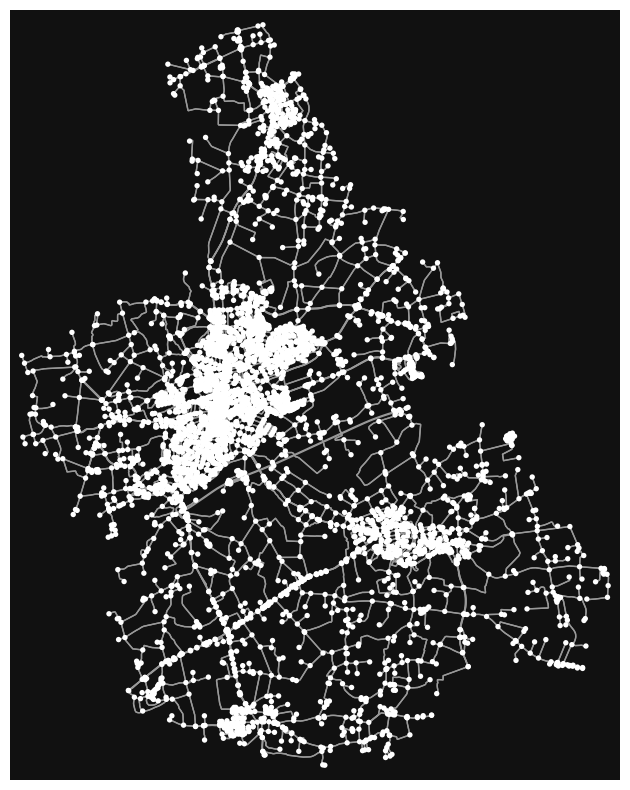

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [4]:
ox.plot_graph(g, figsize=(10, 10))

### Save Data

In [300]:
edges = ox.graph_to_gdfs(g, nodes=False, edges=True)

In [301]:
edges_gdf = gpd.GeoDataFrame(edges, crs=orig_crs)

In [302]:
edges_gdf

osmid       highway lanes maxspeed  \
u           v           key                                            
25270873    10207064748 0    1115969850     secondary     1       50   
            25270883    0     391936459     secondary     1      NaN   
25270874    499376113   0    1115969849     secondary     1       50   
            3710295455  0     391936459     secondary     1      NaN   
25270879    499376139   0      35815425  unclassified   NaN      NaN   
...                                 ...           ...   ...      ...   
13395239165 13395239161 0    1460511115       service   NaN      NaN   
13449603217 6354742567  0      33290693  unclassified     1      NaN   
            859535717   0      33290693  unclassified     1      NaN   
13521086485 429278914   0     683718160   residential   NaN      NaN   
            507623263   0      36687195   residential   NaN       30   

                                              name  oneway    ref reversed  \
u           v           key                                                  
25270873    10207064748 0    Keitlinghauser Straße    True  L 793    False   
            25270883    0                      NaN    True    NaN    False   
25270874    499376113   0             In der Geist    True  L 793    False   
            3710295455  0                      NaN    True    NaN    False   
25270879    499376139   0               Sudbergweg   False    NaN     True   
...                                            ...     ...    ...      ...   
13395239165 13395239161 0                      NaN   False    NaN     True   
13449603217 6354742567  0              Ernstingweg   False    NaN    False   
            859535717   0              Ernstingweg   False    NaN     True   
13521086485 429278914   0      Willy-Brandt-Straße   False    NaN     True   
            507623263   0      Willy-Brandt-Straße    True    NaN    False   

                                 length    junction  \
u           v           key                           
25270873    10207064748 0     10.093885         NaN   
            25270883    0     13.824712  roundabout   
25270874    499376113   0     11.136056         NaN   
            3710295455  0     14.343292  roundabout   
25270879    499376139   0      6.244614         NaN   
...                                 ...         ...   
13395239165 13395239161 0     70.002436         NaN   
13449603217 6354742567  0     78.100740         NaN   
            859535717   0    275.450240         NaN   
13521086485 429278914   0      4.240622         NaN   
            507623263   0     78.844155         NaN   

                                                                      geometry  \
u           v           key                                                      
25270873    10207064748 0      LINESTRING (8.13178 51.80951, 8.13189 51.80945)   
            25270883    0    LINESTRING (8.13178 51.80951, 8.13184 51.80952...   
25270874    499376113   0       LINESTRING (8.13199 51.80969, 8.1321 51.80977)   
            3710295455  0    LINESTRING (8.13199 51.80969, 8.13198 51.80974...   
25270879    499376139   0       LINESTRING (8.1315 51.80956, 8.13143 51.80952)   
...                                                                        ...   
13395239165 13395239161 0    LINESTRING (8.16371 51.82884, 8.16358 51.82882...   
13449603217 6354742567  0       LINESTRING (8.18259 51.86682, 8.18288 51.8675)   
            859535717   0      LINESTRING (8.18259 51.86682, 8.18156 51.86443)   
13521086485 429278914   0      LINESTRING (8.14093 51.83796, 8.14086 51.83796)   
            507623263   0    LINESTRING (8.14093 51.83796, 8.14093 51.83793...   

                            bridge width   service access tunnel  
u           v           key                                       
25270873    10207064748 0      NaN   NaN       NaN    NaN    NaN  
            25270883    0      NaN   NaN       NaN    NaN    NaN  
25270874    499376113   0      

In [303]:
edges_gdf.to_crs(proj_crs, inplace=True)

In [304]:
nodes = ox.graph_to_gdfs(g, nodes=True, edges=False)

In [305]:
nodes.to_crs(proj_crs, inplace=True)

In [306]:
nodes.to_file('nodes.gpkg', driver='GPKG')

In [307]:
edges_gdf.to_file('edges.gpkg', driver='GPKG')

### Convex Hull to create Polygon

In [118]:
hull = edges_gdf.union_all().convex_hull

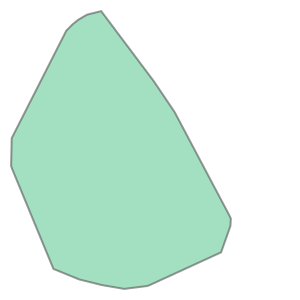

In [119]:
hull

### Generate evenly spaced seed points

In [120]:
latmin, lonmin, latmax, lonmax = hull.bounds

In [121]:
# https://stackoverflow.com/questions/66010964/fastest-way-to-produce-a-grid-of-points-that-fall-within-a-polygon-or-shape
prep_polygon = prep(hull)
points = []
for lat in np.arange(latmin, latmax, seed_point_spacing):
    for lon in np.arange(lonmin, lonmax, seed_point_spacing):
        points.append(Point((round(lat,4), round(lon,4))))

In [122]:
valid_points = []
valid_points.extend(filter(prep_polygon.contains, points))

In [123]:
points_df = pd.DataFrame(valid_points, columns=['Points'])

In [124]:
points_df

,Points
0,POINT (901026.2428 6765923.1417)
1,POINT (901026.2428 6766923.1417)
2,POINT (901026.2428 6767923.1417)
3,POINT (901026.2428 6768923.1417)
4,POINT (901026.2428 6769923.1417)
...,...
297,POINT (918026.2428 6764923.1417)
298,POINT (918026.2428 6765923.1417)
299,POINT (919026.2428 6761923.1417)
300,POINT (919026.2428 6762923.1417)


In [125]:
points_gdf = gpd.GeoDataFrame(points_df, crs=proj_crs, geometry='Points')

In [126]:
points_gdf.to_crs(proj_crs)

,Points
0,POINT (901026.243 6765923.142)
1,POINT (901026.243 6766923.142)
2,POINT (901026.243 6767923.142)
3,POINT (901026.243 6768923.142)
4,POINT (901026.243 6769923.142)
...,...
297,POINT (918026.243 6764923.142)
298,POINT (918026.243 6765923.142)
299,POINT (919026.243 6761923.142)
300,POINT (919026.243 6762923.142)


<Axes: >

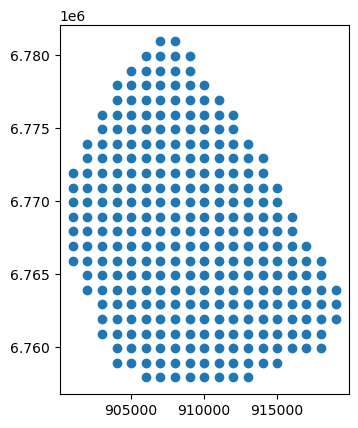

In [127]:
points_gdf.plot()

### Snap Seed points to OSM nodes

In [128]:
# https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
nA = np.array(list(points_gdf.geometry.apply(lambda x: (x.x, x.y))))
nB = np.array(list(nodes.geometry.apply(lambda x: (x.x, x.y))))
btree = cKDTree(nB)
dist, idx = btree.query(nA, k=1)
gdB_nearest = nodes.iloc[idx].drop(columns="geometry").reset_index(drop=True)
gdf = pd.concat(
    [
        points_gdf.reset_index(drop=True),
        gdB_nearest,
        pd.Series(dist, name='dist')
    ],
    axis=1)

In [129]:
gdf_cleaned = gdf.drop(gdf[gdf.dist > delta].index)
gdf_cleaned

,Points,y,x,street_count,nodeID,highway,ref,dist
1,POINT (901026.243 6766923.142),51.816901,8.095518,4,442,NaN,NaN,230.346898
2,POINT (901026.243 6767923.142),51.820981,8.094855,4,962,NaN,NaN,135.334443
3,POINT (901026.243 6768923.142),51.826974,8.094031,1,1931,NaN,NaN,22.941959
4,POINT (901026.243 6769923.142),51.831652,8.096989,1,3212,NaN,NaN,372.819309
5,POINT (901026.243 6770923.142),51.837113,8.092713,1,4524,NaN,NaN,246.894727
...,...,...,...,...,...,...,...,...
296,POINT (918026.243 6763923.142),51.798508,8.247702,1,4960,NaN,NaN,181.001635
297,POINT (918026.243 6764923.142),51.804452,8.248334,3,1493,NaN,NaN,190.880517
299,POINT (919026.243 6761923.142),51.787468,8.252937,3,2031,NaN,NaN,341.445630
300,POINT (919026.243 6762923.142),51.794261,8.256002,1,5143,NaN,NaN,91.491374


In [146]:
snapped_points = nodes.loc[nodes['nodeID'].isin(gdf_cleaned['nodeID'])]

In [147]:
snapped_points.drop(columns=['y', 'x','street_count', 'highway', 'ref'], inplace=True)

/var/folders/0t/3k3_vhb54dgb_d5kncl6k_x00000gn/T/ipykernel_72773/1855639553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapped_points.drop(columns=['y', 'x','street_count', 'highway', 'ref'], inplace=True)


In [148]:
snapped_points

,nodeID,geometry
osmid,,
278351834,129,POINT (914844.325 6763930.873)
278353908,171,POINT (910992.526 6762096.844)
278355106,174,POINT (909998.076 6760645.723)
278355124,176,POINT (912159.377 6761136.275)
278355141,178,POINT (913014.856 6762091.535)
...,...,...
12460569942,5174,POINT (915095.395 6766849.549)
12573586854,5317,POINT (909234.791 6763846.163)
12870121474,5341,POINT (914894.953 6765851.651)


In [151]:
snapped_points['osmID'] = snapped_points.index

In [152]:
snapped_points

,nodeID,geometry,osmID
osmID,,,
278351834,129,POINT (914844.325 6763930.873),278351834
278353908,171,POINT (910992.526 6762096.844),278353908
278355106,174,POINT (909998.076 6760645.723),278355106
278355124,176,POINT (912159.377 6761136.275),278355124
278355141,178,POINT (913014.856 6762091.535),278355141
...,...,...,...
12460569942,5174,POINT (915095.395 6766849.549),12460569942
12573586854,5317,POINT (909234.791 6763846.163),12573586854
12870121474,5341,POINT (914894.953 6765851.651),12870121474


<Axes: >

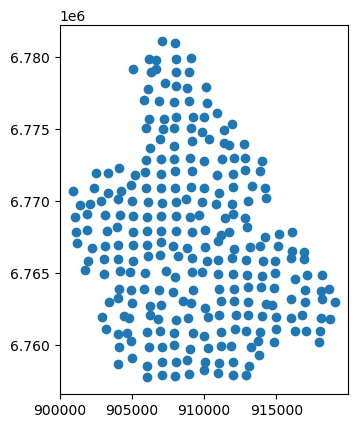

In [153]:
snapped_points.plot()

### Greedy triangulation

In [154]:
pairs = []
edges = []
distances = []

for pair in combinations(snapped_points["osmID"], 2):

    edge = LineString(snapped_points.loc[list(pair)].geometry)

    pairs.append(pair)
    edges.append(edge)
    distances.append(edge.length)

df = pd.DataFrame(
    {
        "pair": pairs,
        "e": edges,
        "dist": distances
    }
)

df = df.sort_values(by="dist", ascending=True).reset_index(drop=True)
df = df[df["dist"]>0].reset_index(drop=True) # only keep distances > 0
df.tail(10)

,pair,e,dist
35235,"(6360954799, 8872324199)",LINESTRING (907037.1554444014 6781067.22749632...,23244.639451
35236,"(2702087981, 11940368273)",LINESTRING (906062.3640593719 6757758.16488605...,23253.100998
35237,"(2702087981, 6360954799)",LINESTRING (906062.3640593719 6757758.16488605...,23329.436727
35238,"(3358885447, 6360954799)",LINESTRING (913134.3577260795 6758529.80940448...,23347.614223
35239,"(2457563812, 11940368273)",LINESTRING (911966.6051357092 6757933.82817607...,23351.443404
35240,"(3297963546, 6360954799)",LINESTRING (910981.9397118464 6758042.50892374...,23360.200947
35241,"(286933756, 6360954799)",LINESTRING (917953.2337671823 6760234.67382140...,23519.269941
35242,"(281837729, 11940368273)",LINESTRING (912884.7794277212 6757929.00754767...,23531.895224
35243,"(2457563812, 6360954799)",LINESTRING (911966.6051357092 6757933.82817607...,23652.772319
35244,"(281837729, 6360954799)",LINESTRING (912884.7794277212 6757929.00754767...,23865.706121


In [155]:
# helper function
def intersects_properly(geom1, geom2):
    '''
    for 2 shapely geometries, check whether they "properly intersect" (i.e. intersect but not touch, i.e. don't share endpoints)
    '''
    return geom1.intersects(geom2) and not geom1.touches(geom2)

In [156]:
# this should work, is suuuper slow tho (keyboard interrupt after 23 minutes)
# number of edges needs to be reduced

current_edges = MultiLineString()
edge_list = []

# go through all node pair combinations, if they dont intersect with existing edges add to multilinestring
for _, row in df.iterrows():
    new_edge = row.e
    pair = row.pair
    if not intersects_properly(current_edges, new_edge):
        current_edges = MultiLineString([linestring for linestring in current_edges.geoms] + [new_edge])
        edge_list.append(pair)

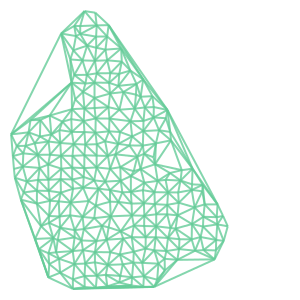

In [157]:
current_edges

In [158]:
A = nx.Graph()
A.add_nodes_from(snapped_points.index)
A.add_edges_from(edge_list)

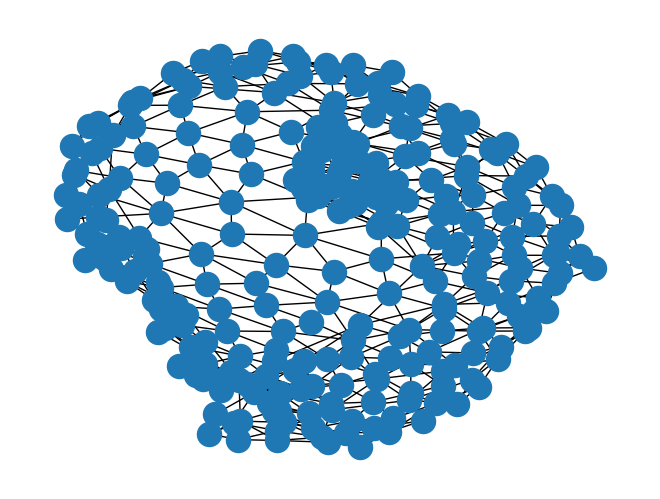

In [159]:
nx.draw(A)

### Add edge attribute betweenness to A

In [160]:
bc_values = nx.edge_betweenness_centrality(A, normalized=True)

In [161]:
nx.set_edge_attributes(A, bc_values, name='betweenness_centrality')

### Add node attribute closeness to A

In [162]:
closeness = nx.closeness_centrality(A)

In [163]:
nx.set_node_attributes(A, closeness, name='closeness_centrality')

### Export Edges, Nodes from A to df

In [164]:
# https://stackoverflow.com/questions/62383699/converting-networkx-graph-to-data-frame-with-its-attributes
def make_node_df(G):
    nodes = {}
    for node, attribute in G.nodes(data=True):
        if not nodes.get('node'):
            nodes['node'] = [node]
        else:
            nodes['node'].append(node)

        for key, value in attribute.items():
            if not nodes.get(key):
                nodes[key] = [value]
            else:
                nodes[key].append(value)

    return pd.DataFrame(nodes)

In [165]:
# https://stackoverflow.com/questions/62383699/converting-networkx-graph-to-data-frame-with-its-attributes
def make_edge_df(G):
    edges = {}
    for source, target, attribute in G.edges(data=True):
        if not edges.get('source'):
            edges['source'] = [source]
        else:
            edges['source'].append(source)

        if not edges.get('target'):
            edges['target'] = [target]
        else:
            edges['target'].append(target)
        for key, value in attribute.items():
            if not edges.get(key):
                edges[key] = [value]
            else:
                edges[key].append(value)
    return pd.DataFrame(edges)

In [166]:
a_edges = make_edge_df(A)

In [167]:
a_nodes = make_node_df(A)

### Rank edges by attribute

In [168]:
a_edges_ordered = a_edges.copy(deep=True)

In [169]:
a_edges_ordered = a_edges_ordered.sort_values(by='betweenness_centrality', ascending = False)

### Routing between seed points

In [171]:
a_edges_ordered

,source,target,betweenness_centrality
670,3950087388,8664760647,0.097290
127,393436154,3950087388,0.096757
340,482855661,6790573228,0.095450
604,2702087981,8664760647,0.090348
747,6790573228,6838087225,0.086495
...,...,...,...
500,1033361183,2304507001,0.000296
643,3358885447,7207960534,0.000285
658,3642201401,10270111698,0.000266
618,2734126597,11940368273,0.000221


In [186]:
paths = []
for _, row in a_edges_ordered.iterrows():
    source = row.source
    target = row.target
    try:
        path = nx.shortest_path(g, source, target, weight='length')
        paths.append(path)
    except:
        pass

In [211]:
# found solution without zip, navigating edge reverse problem. nested for-loop is not nice tho, improvement needed
edge_tuples = []
for i in range(len(paths)):
    for j in range(len(g)):
        try:
            edge_tuple = paths[i][j], paths[i][j+1]
            edge_tuples.append(edge_tuple)
        except:
            pass

In [267]:
list_of_edges = []
for i in range(len(edge_tuples)):
    edge = g.get_edge_data(edge_tuples[i][0], edge_tuples[i][1])
    list_of_edges.append(edge)

In [282]:
routed_edges_df = pd.json_normalize(list_of_edges)
routed_edges_df = routed_edges_df.iloc[:,0:10]
routed_edges_df.columns = ['osmid','highway','lanes','maxspeed','name','ref','oneway','reversed','length','geometry']

In [286]:
routed_edges_gdf = gpd.GeoDataFrame(routed_edges_df, crs=orig_crs, geometry='geometry')
routed_edges_gdf.to_crs(proj_crs, inplace=True)

In [291]:
routed_edges_gdf

,osmid,highway,lanes,maxspeed,name,ref,oneway,reversed,length,geometry
0,863085314,secondary,2,100,Vellerner Straße,L 882,False,False,112.054694,"LINESTRING (901698.429 6765245.032, 901745.583..."
1,863085314,secondary,2,100,Vellerner Straße,L 882,False,False,290.238970,"LINESTRING (901774.07 6765409.911, 901810.115 ..."
2,408886402,unclassified,1,NaN,Sudbergweg,NaN,False,False,442.003638,"LINESTRING (901928.86 6765853.038, 901934.738 ..."
3,408886402,unclassified,1,NaN,Sudbergweg,NaN,False,False,4.415157,None
4,408886402,unclassified,1,NaN,Sudbergweg,NaN,False,False,52.870081,"LINESTRING (902646.214 6765910.33, 902650.589 ..."
...,...,...,...,...,...,...,...,...,...,...
7297,131710106,unclassified,NaN,NaN,Im Aschenbrock,NaN,False,False,408.375666,"LINESTRING (906674.788 6779803.961, 906685.698..."
7298,131710105,unclassified,NaN,NaN,Im Aschenbrock,NaN,False,False,200.986582,"LINESTRING (906676.569 6779146.829, 906672.74 ..."
7299,131710105,unclassified,NaN,NaN,Im Aschenbrock,NaN,False,False,216.508803,"LINESTRING (906402.69 6779008.037, 906411.551 ..."
7300,"[630926237, 192484806]","[track, service]",NaN,NaN,NaN,NaN,False,True,184.563382,"LINESTRING (906522.926 6778678.27, 906333.672 ..."


In [371]:
edges_gdf['path'] = edges_gdf.index

In [372]:
needed_edge_ids = routed_edges_gdf['osmid'].tolist()

In [373]:
needed_edges_gdf = edges_gdf[edges_gdf['osmid'].isin(needed_edge_ids)]

In [374]:
needed_edges_gdf['path'] = needed_edges_gdf['path'].astype(str)
needed_edges_gdf['path'] = needed_edges_gdf[('path')].map(lambda x: x.lstrip('(').rstrip(')'))

/Users/manuel/geospatial_test/.pixi/envs/default/lib/python3.12/site-packages/geopandas/geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [378]:
needed_edges_gdf[['source','target','key']] = pd.DataFrame(needed_edges_gdf.path.str.split(',',n=2, expand=True))

/Users/manuel/geospatial_test/.pixi/envs/default/lib/python3.12/site-packages/geopandas/geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/manuel/geospatial_test/.pixi/envs/default/lib/python3.12/site-packages/geopandas/geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/manuel/geospatial_test/.pixi/envs/default/lib/python3.12/site-packages/geopandas/geodataframe.py:1969: SettingWithCopyWarning: 
A

In [379]:
needed_edges_gdf

osmid       highway lanes maxspeed  \
u           v           key                                            
25270873    10207064748 0    1115969850     secondary     1       50   
            25270883    0     391936459     secondary     1      NaN   
25270874    499376113   0    1115969849     secondary     1       50   
            3710295455  0     391936459     secondary     1      NaN   
25270879    499376139   0      35815425  unclassified   NaN      NaN   
...                                 ...           ...   ...      ...   
13395239165 414054514   0     254350974   residential   NaN       30   
13449603217 6354742567  0      33290693  unclassified     1      NaN   
            859535717   0      33290693  unclassified     1      NaN   
13521086485 429278914   0     683718160   residential   NaN      NaN   
            507623263   0      36687195   residential   NaN       30   

                                              name  oneway    ref reversed  \
u           v           key                                                  
25270873    10207064748 0    Keitlinghauser Straße    True  L 793    False   
            25270883    0                      NaN    True    NaN    False   
25270874    499376113   0             In der Geist    True  L 793    False   
            3710295455  0                      NaN    True    NaN    False   
25270879    499376139   0               Sudbergweg   False    NaN     True   
...                                            ...     ...    ...      ...   
13395239165 414054514   0                    Uthof   False    NaN     True   
13449603217 6354742567  0              Ernstingweg   False    NaN    False   
            859535717   0              Ernstingweg   False    NaN     True   
13521086485 429278914   0      Willy-Brandt-Straße   False    NaN     True   
            507623263   0      Willy-Brandt-Straße    True    NaN    False   

                                 length    junction  \
u           v           key                           
25270873    10207064748 0     10.093885         NaN   
            25270883    0     13.824712  roundabout   
25270874    499376113   0     11.136056         NaN   
            3710295455  0     14.343292  roundabout   
25270879    499376139   0      6.244614         NaN   
...                                 ...         ...   
13395239165 414054514   0     28.588536         NaN   
13449603217 6354742567  0     78.100740         NaN   
            859535717   0    275.450240         NaN   
13521086485 429278914   0      4.240622         NaN   
            507623263   0     78.844155         NaN   

                                                                      geometry  \
u           v           key                                                      
25270873    10207064748 0    LINESTRING (905225.542 6765755.145, 905238.377...   
            25270883    0    LINESTRING (905225.542 6765755.145, 905232.488...   
25270874    499376113   0    LINESTRING (905249.398 6765788.472, 905261.12 ...   
            3710295455  0    LINESTRING (905249.398 6765788.472, 905247.884...   
25270879    499376139   0    LINESTRING (905194.206 6765764.184, 905186.948...   
...                                                                        ...   
13395239165 414054514   0    LINESTRING (908779.639 6769237.149, 908794.556...   
13449603217 6354742567  0    LINESTRING (910881.607 6776081.433, 910913.935...   
            859535717   0    LINESTRING (910881.607 6776081.433, 910767.605...   
13521086485 429278914   0    LINESTRING (906243.648 6770879.623, 906236.779...   
            507623263   0    LINESTRING (906243.648 6770879.623, 906244.349...   

                            bridge width service access tunnel       source  \
u           v           key                                                   
25270873    10207064748 0      NaN   NaN     NaN    NaN    NaN     25270873   
            25270883    0      NaN   NaN     NaN    NaN    NaN